# Questions to answer

Please write your answers on paper and include them in your folder.  We unfortunately likely won't have time to review them until this weekend, but we would like the opportunity to see how you are thinking about and discussing these questions with your group.

## XOR network
1. How does the XOR network here differ from the one we built yesterday?
2. How does that difference impact the network's ability to classify?
2. How does PyTorch handle creating network layers?
3. How does PyTorch handle training networks?
4. How does PyTorch handle testing networks?

## $\geq 5$ network
1. How much better is performance using this network architecture?
2. What modifications can you make to the network architecture or learning rate to result in better accuracy?
3. How long does this network take to train before it stops improving or changing?

## Digit classification network
1. What accuracy does this network have?
2. How many parameters does this network have?

4. How long does this network take to train before it stops improving or changing?

## Challenge problems
1. A common activation function used now is the ReLU activation function.  Based on the PyTorch documentation at https://pytorch.org/docs/stable/index.html, how is it defined?  What impact does it have on your networks if you use it instead of tanh?
3. In the PyTorch documentation there are other loss functions we can use.  What impact might switching the loss function have?

# Imports

In [2]:
import sys
sys.path.append('C:\Program Files\Python37\Lib\site-packages')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

# Datasets

In [3]:
# MNIST data
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST('MNIST/', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST('MNIST/', train=False, transform=transform, download=True)

MNIST_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
MNIST_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)



# XOR data
xor_inputs = torch.tensor(np.array([[1.0, 1], [0, 1], [1, 0], [0, 0]])).float()
xor_labels = torch.tensor(np.array([0, 1, 1, 0])).float().view(-1, 1)

xor_dataset = torch.utils.data.TensorDataset(xor_inputs, xor_labels)
xor_loader = torch.utils.data.DataLoader(xor_dataset, batch_size=4)



x = np.linspace(-10, 20, 100)
y = np.linspace(-10, 20, 100)
xv, yv = np.meshgrid(x, y)

x = xv.reshape(-1, 1)
y = yv.reshape(-1, 1)

xor_grid = torch.tensor(np.concatenate((x, y), axis=1)).float()

# XOR Network

In [4]:
class XORNet(nn.Module):
    def __init__(self):
        super(XORNet, self).__init__()
        self.fc1 = nn.Linear(2, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 1)
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
n_epochs = 10000
network = XORNet()
optimizer = optim.SGD(network.parameters(), lr=0.01)

lossFunc = torch.nn.MSELoss()

In [6]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(xor_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = lossFunc(output, target)
        loss.backward()
        optimizer.step()

In [7]:
def test():
    network.eval()
    correct = 0
    with torch.no_grad():
        for data, target in xor_loader:
            output = network(data)
            pred = output.data
            correct += (pred > 0.5).long().eq(target.data.view_as(pred).long()).sum()
    return 100. * correct / len(xor_loader.dataset)

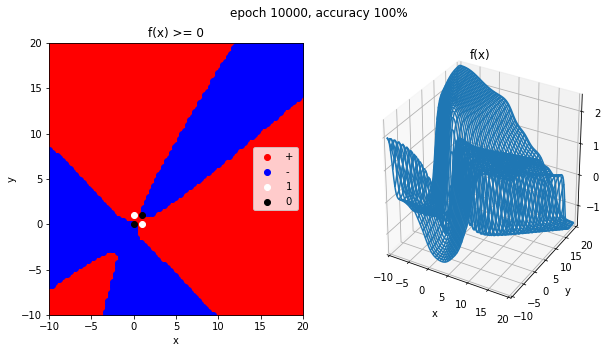

In [8]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    if epoch % 50 == 0:
        ax1.clear()
        ax2.clear()
        
        
        #print('Epoch {}'.format(epoch))
        acc = test()
        
        res = network(xor_grid).detach().numpy()
        
        ax1.scatter(x[res >= 0], y[res >= 0], c='r', label='+')
        ax1.scatter(x[res < 0], y[res < 0], c='b', label='-')
        ax1.scatter(1, 0, c='w', label='1')
        ax1.scatter(0, 1, c='w')
        ax1.scatter(1, 1, c='k', label='0')
        ax1.scatter(0, 0, c='k')
        ax1.set_title('f(x) >= 0')
        ax1.set_xlim([-10, 20])
        ax1.set_ylim([-10, 20])
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.legend()
        
        
        ax2.plot_wireframe(xv, yv, res.reshape(xv.shape))
        ax2.set_title('f(x)')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_xlim([-10, 20])
        ax2.set_ylim([-10, 20])
        
        fig.suptitle('epoch {}, accuracy {:.0f}%'.format(epoch, acc))
        
        fig.canvas.draw()
        fig.canvas.flush_events()

# $\geq 5$ network

In [73]:
class greaterFiveNet(nn.Module):
    def __init__(self):
        super(greaterFiveNet, self).__init__()
        self.conv = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(13*13*32, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, 1)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.activation(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [74]:
n_epochs = 1000
network = greaterFiveNet()

optimizer = optim.SGD(network.parameters(), lr=1)

lossFunc = torch.nn.MSELoss()

In [75]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(MNIST_train_loader):
        optimizer.zero_grad()
        output = network(data)
        target = (target >= 5).float().view_as(output)
        loss = lossFunc(output, target)
        loss.backward()
        optimizer.step()

In [76]:
def test():
    network.eval()
    correct = 0
    with torch.no_grad():
        for data, target in MNIST_test_loader:
            output = network(data)
            pred = output.data
            correct += (pred > 0.5).long().eq((target >= 5).data.view_as(pred).long()).sum()
    print('Test set: Accuracy: {}/{} ({:.0f}%)'.format(
          correct, len(MNIST_test_loader.dataset),
          100. * correct / len(MNIST_test_loader.dataset)))

In [77]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    print('Epoch {}'.format(epoch))
    #fig, ax = plt.subplots(10, 30, figsize = (30, 10))
    '''for i in range(10):
        for j in range(30):
            ax[i, j].imshow(network.fc1.weight[i*30 + j, :].detach().numpy().reshape(28, 28), cmap='gray', interpolation='none')
            ax[i, j].axis('off')
    print(network.fc3.weight)'''

    test()

Test set: Accuracy: 5139/10000 (51%)
Epoch 1
Test set: Accuracy: 5139/10000 (51%)


KeyboardInterrupt: 

# Digit classification network

In [56]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(13*13*32, 250)
        self.fc2 = nn.Linear(250, 100)
        self.fc3 = nn.Linear(100, 10)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.activation(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [57]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=1)

In [58]:
lossFunc = torch.nn.MSELoss()

In [59]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(MNIST_train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = lossFunc(output, F.one_hot(target, 10).float())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            pred = output.data.max(1, keepdim=True)[1]
            correct = pred.eq(target.data.view_as(pred)).sum()
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAccuracy: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(MNIST_train_loader.dataset),
                  100. * batch_idx / len(MNIST_train_loader), 100. * correct.numpy() / 64))
            #print(network.fc1.weight)
            #plt.imshow(network.fc1.weight.detach().numpy().reshape(28, 28), cmap='gray', interpolation='none')

In [60]:
def test():
    network.eval()
    correct = 0
    with torch.no_grad():
        for data, target in MNIST_test_loader:
            output = network(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
          correct.numpy(), len(MNIST_test_loader.dataset),
          100. * correct.numpy() / len(MNIST_test_loader.dataset)))

In [61]:
test()

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()



Test set: Accuracy: 778/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Accuracy: 6.250000
Train Epoch: 1 [6400/60000 (11%)]	Accuracy: 85.937500
Train Epoch: 1 [12800/60000 (21%)]	Accuracy: 93.750000
Train Epoch: 1 [19200/60000 (32%)]	Accuracy: 93.750000
Train Epoch: 1 [25600/60000 (43%)]	Accuracy: 93.750000
Train Epoch: 1 [32000/60000 (53%)]	Accuracy: 93.750000
Train Epoch: 1 [38400/60000 (64%)]	Accuracy: 95.312500
Train Epoch: 1 [44800/60000 (75%)]	Accuracy: 93.750000
Train Epoch: 1 [51200/60000 (85%)]	Accuracy: 96.875000
Train Epoch: 1 [57600/60000 (96%)]	Accuracy: 95.312500

Test set: Accuracy: 9764/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Accuracy: 96.875000
Train Epoch: 2 [6400/60000 (11%)]	Accuracy: 96.875000
Train Epoch: 2 [12800/60000 (21%)]	Accuracy: 98.437500
Train Epoch: 2 [19200/60000 (32%)]	Accuracy: 96.875000
Train Epoch: 2 [25600/60000 (43%)]	Accuracy: 98.437500
Train Epoch: 2 [32000/60000 (53%)]	Accuracy: 96.875000
Train Epoch: 2 [38400/60000 (64%)]	Accuracy: 98.437500
Tr

KeyboardInterrupt: 